# Point source removal

The algorithm proceeds as follows:
1. For all galaxies, extract a subpatch centered in its galaxy position
2. Within a radius of 3 arcmin, compute median and 68 percentile sigma
3. Take the q=2 brightest pixels within the radius and normalize their excess in units of sigma
4. Impose a sigma cut, ie: submaps with q brightest pixels larger than median + 3.65 sigma are rejected.

The 3.65 sigma value was picked to give ~3000 rejected galaxies with a n estimated false positive rate of 6%. For the estimation I used a Gaussian distribution of pixels.

Output file has one column added "use_(PS)" which contains True if you should use it or False if not.

In [1]:
import glob
import pandas as pd
from pixell import enmap
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from matplotlib import gridspec

In [2]:
fname = glob.glob('/nfs/grp/cosmo/kSZ/DR15_actplanck_catalog_wbestObjID_PetrANDcModel_20200902_EMV_evavagiakis.csv')
df = pd.read_csv(fname[0])

print('Catalog Length: %i' %len(df))
#df = df.query('coaddedanalysis==1 or coaddedanalysis==2')

Catalog Length: 602461


In [3]:
#df_outliers = df.query('dT > 50 or dT<-50')

In [4]:
from pixell import enmap
map_fname = r'/nfs/grp/cosmo/kSZ/actpol/map_coadd/20200228/release/act_planck_s08_s18_cmb_f150_night_map.fits'
themap = enmap.read_fits(map_fname)[0,:,:]

def box(ra_deg, dec_deg, width_arcmin=10):
    ra_rad, dec_rad, width_rad = np.deg2rad([ra_deg, dec_deg, width_arcmin/60.])
    thebox = [[dec_rad - width_rad*0.5, ra_rad - width_rad*0.5],
              [dec_rad + width_rad*0.5, ra_rad + width_rad*0.5]]
    return thebox

In [5]:
rmax_photometry_arcmin = 3.0 # Radius at which to look for weird pixels
sigma_threshold = 3.65

In [6]:
def extract_photometry_submap_values(submap, rmax_photometry_arcmin):
    '''rmax_photometry_arcmin: maximum radial distance in the ap photo'''
    r_arcmin = 60 * np.rad2deg(submap.modrmap()) 
    sel = r_arcmin < rmax_photometry_arcmin
    photometry_values = submap[sel].flatten()
    return photometry_values

In [7]:
def photometry_map_stats(photometry_values):
    '''From a vector of pixel values, extract
    the median 68%sigma and the four brightest pixel value'''
    median = np.median(photometry_values)
    median_minus_sigma = np.percentile(photometry_values, 50-68/2)
    median_plus_sigma = np.percentile(photometry_values, 50+68/2)
    sigma = 0.5 * (median_plus_sigma-median_minus_sigma)
    brightest_q_pix = np.sort(photometry_values)[-2]
    
    class submap_stats:
        def __init__(self, median, sigma, brightest_q_pix):
            self.median = median
            self.sigma = sigma
            self.brightest_q_pix = brightest_q_pix
            self.brightest_q_pix_distance_in_sigmas = (brightest_q_pix - median)/sigma 
    stats = submap_stats(median, sigma, brightest_q_pix)
    return stats

In [8]:
#stats = photometry_map_stats(photometry_values)

In [9]:
#stats.brightest_q_pix_distance_in_sigmas

# Run the predictor on all the dataset without filtering

In [10]:
#df = pd.concat([pd.read_csv(fname) for fname in fnames], ignore_index=True)

print('Catalog Length: %i' %len(df))

Catalog Length: 602461


In [11]:
sigma_score = np.zeros(len(df))
for j in progressbar.progressbar(range(len(df))):
    thebox = box(df.ra.values[j], df.dec.values[j])
    submap = themap.submap(thebox)
    
    photometry_values = extract_photometry_submap_values(submap, rmax_photometry_arcmin)
    stats = photometry_map_stats(photometry_values)
    sigma_score[j] = stats.brightest_q_pix_distance_in_sigmas

 29% (177177 of 602461) |####            | Elapsed Time: 0:32:29 ETA:   1:21:44/nfs/user/pag227/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
 30% (181050 of 602461) |####            | Elapsed Time: 0:33:11 ETA:   1:17:39/nfs/user/pag227/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
100% (602461 of 602461) |################| Elapsed Time: 1:50:25 Time:  1:50:25


In [12]:
df['sigma_score'] = sigma_score
df_3_sigma_cut = df.query('sigma_score > %1.2f' %sigma_threshold)
print(df_3_sigma_cut.shape)
sigma_score_cut = np.ones(len(df), dtype=bool) # pass 1, reject 0
sel = sigma_score > sigma_threshold
sigma_score_cut[sel] = False
df['use_PS'] = sigma_score_cut

(3799, 30)


/nfs/user/pag227/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [13]:
df.head()

,ra,dec,z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,cModelMagErr_u,cModelMagErr_g,...,petroMagErr_i,petroMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,bestObjID,sigma_score,use_PS
0,239.86289,17.711100,0.470891,23.42323,21.98307,20.48035,19.53766,19.42141,1.415560,0.133026,...,0.095018,0.277362,0.166446,0.129693,0.089721,0.066672,0.049592,1237665428108411323,1.897764,True
1,240.22034,17.630112,0.461956,25.23561,22.22880,20.67365,19.70656,19.58069,0.823770,0.158354,...,0.098714,0.421514,0.187626,0.146197,0.101138,0.075157,0.055903,1237665428108542821,2.684052,True
2,240.23549,17.657548,0.542056,22.60199,22.15313,20.48327,19.55257,19.26793,0.358379,0.089716,...,0.305553,0.320707,0.184350,0.143644,0.099373,0.073844,0.054927,1237665428108542828,2.783213,True
3,240.26026,17.577039,0.354384,19.70485,21.06691,19.27010,18.67133,18.32766,0.273976,0.096407,...,0.095913,0.225354,0.184146,0.143486,0.099263,0.073763,0.054866,1237665428108608111,2.066332,True
4,240.40951,17.570931,0.626872,22.75388,22.42253,20.79306,19.59270,18.91076,1.002837,0.201570,...,0.087484,0.196922,0.169795,0.132303,0.091527,0.068014,0.050590,1237665428108608463,2.149047,True


In [14]:
df.to_csv('/nfs/grp/cosmo/kSZ/PAG20200416_DR15_point_source_removal_PAG09232020.csv')

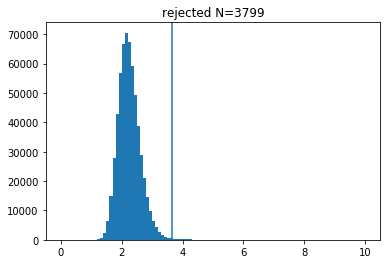

In [15]:
plt.hist(df.sigma_score.values[np.isfinite(df.sigma_score.values)], range=[0, 10], bins=100);
plt.title('rejected N=%i' % len(df_3_sigma_cut))
plt.axvline(sigma_threshold)

In [16]:
df_toplot = df.query('use_PS == False')[:300]
print(df_toplot.shape)

(300, 31)


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


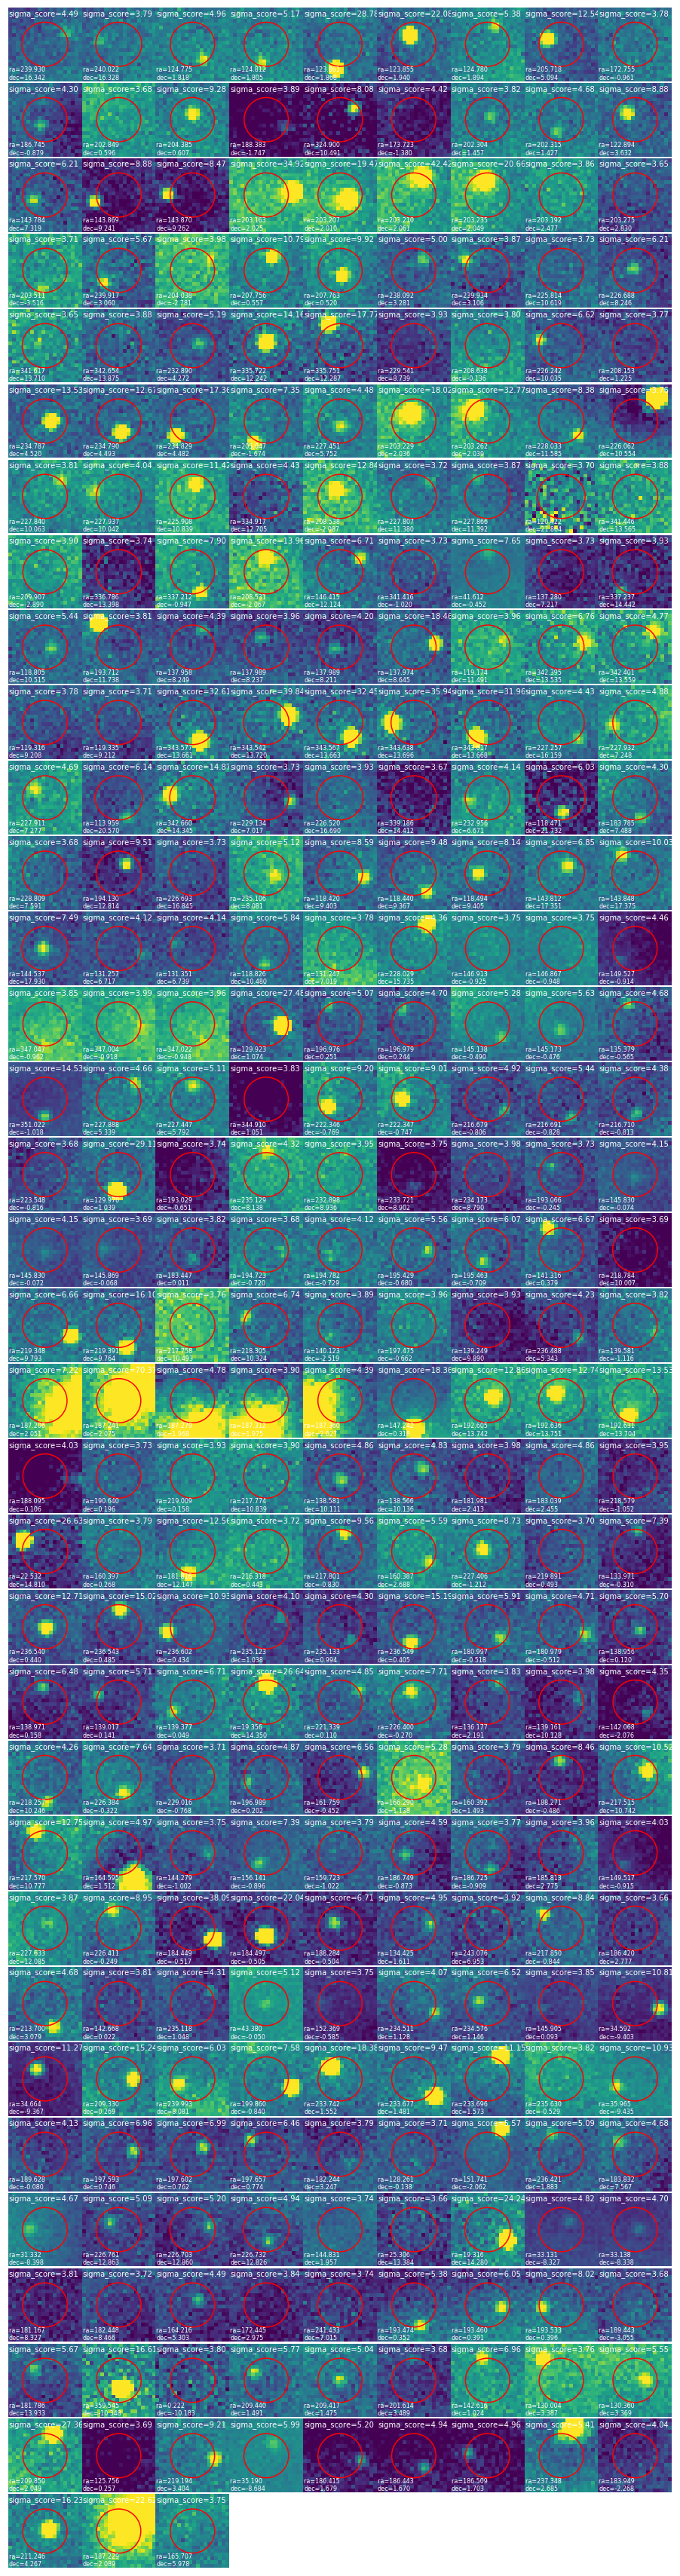

In [17]:
Ncols = 9
Nrows = int(np.ceil(len(df_toplot)/(1.0*Ncols)))
plot_scale = 1.4

plt.figure(figsize=plot_scale * np.array([Ncols, Nrows]))
gs = gridspec.GridSpec(Nrows, Ncols)
gs.update(wspace=0, hspace=0)
all_stats = []

for j in progressbar.progressbar(range(len(df_toplot))):
    thebox = box(df_toplot.ra.values[j], df_toplot.dec.values[j])
    submap = themap.submap(thebox)
    
    photometry_values = extract_photometry_submap_values(submap, rmax_photometry_arcmin)
    stats = photometry_map_stats(photometry_values)
    all_stats.append(stats)
    
    if stats.brightest_q_pix_distance_in_sigmas > sigma_threshold:
        colormap = 'autumn'
    else:
        colormap= 'twilight'
    
    ax = plt.subplot(gs[j]) # , projection=submap.wcs)
    median = np.median(submap)
    #ax.imshow(submaps[j], vmin=median-150, vmax=median+150)
    
    
    ax.imshow(submap, vmin=-200, vmax=500)
    ax.contour(60 * np.rad2deg(submap.modrmap()), levels=[rmax_photometry_arcmin], cmap=colormap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.annotate('sigma_score=%1.2f' % (stats.brightest_q_pix_distance_in_sigmas), 
                xy=(0.01, 0.98),
                xycoords='axes fraction', color='white', fontsize=10, verticalalignment='top')
    ax.annotate('ra=%1.3f \ndec=%1.3f' %(df_3_sigma_cut.ra.values[j], df_3_sigma_cut.dec.values[j]),
                xy=(0.01, 0.03), xycoords='axes fraction', color='white', fontsize=8)
plt.tight_layout()
plt.savefig('fist300_PS.png', dpi=150)

# Simulate false positive rate

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [19]:
N_pix_disk = 200
q_brightest_pix = 2
N_realizations = 600000
threshold = sigma_threshold

In [20]:
realizations = np.random.normal(size=[N_realizations,N_pix_disk])
max_q = np.sort(realizations, axis=-1)[:, -q_brightest_pix]

Text(0.5,1,'q_th brightest pixel distribution from gaussian priors: with q =2')

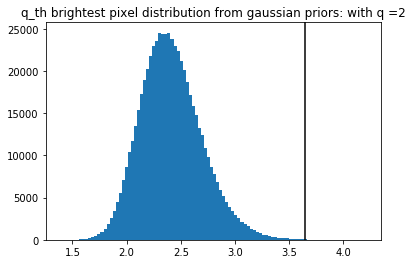

In [21]:
plt.hist(max_q, bins=100)
plt.axvline(threshold, color='black')
plt.title('q_th brightest pixel distribution from gaussian priors: with q =%i' %(q_brightest_pix))

In [22]:
print('Percentile above %1.2f sigma: %1.2f' %(threshold, 100-scipy.stats.percentileofscore(max_q, threshold)))
(1-scipy.stats.percentileofscore(max_q, threshold)/100) * N_realizations

Percentile above 3.65 sigma: 0.03


199.99999999997797

In [23]:
false_rejections = (1-scipy.stats.percentileofscore(max_q, threshold)/100) * N_realizations
total_rejections = df_3_sigma_cut.shape[0]
fpr = false_rejections/total_rejections
print('false positive rate: %1.2f' % (fpr))

false positive rate: 0.05
